In [1]:
# default_exp core-sequence

# Actions in video

> API details.

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
import os
import pathlib
import time
import datetime
from tqdm.notebook import tqdm

import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd import Variable

from actions_in_videos.dataset_ucf101 import UCF101, SequenceDataset, DataLoader
from actions_in_videos.models import ResNet50Classifier, ConvLSTM
from actions_in_videos.dataset_ucf101 import SequenceBatchShower

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%matplotlib inline

In [6]:
print('torch.__version__', torch.__version__)

torch.__version__ 1.4.0


Create a directory to save the models if it does not exists:

In [7]:
save_dir = pathlib.Path('model-checkpoints')
save_dir.mkdir(parents=True, exist_ok=True)

Define model and run options:

In [8]:
opt = {
    'channels':3,
    'img_dim':224,
    'sequence-length':16,
    'latent-dim': 512,
    'sample-interval': 1,
    'dataset-path': '../data/UCF101/',
    'batch-size': 32,
    'learning-rate': 0.0001,
    'num-epochs': 20,
    'checkpoint_interval': 10,
    'checkpoint-model': False
      }

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_shape = (opt['channels'], opt['img_dim'], opt['img_dim'])

# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

## Create the Training set and its associated Dataloader:

In [10]:
# Define training set
train_ds = SequenceDataset(
    dataset_path=opt['dataset-path'],
    sequence_length=opt['sequence-length'],
    sample_interval=opt['sample-interval'],
    training=True,
    transform=transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop((224, 224)),
        transforms.Resize((opt['img_dim'], opt['img_dim']), Image.BICUBIC), 
        transforms.ToTensor(), 
        transforms.Normalize(mean, std),
    ])
)

train_dl = DataLoader(train_ds, batch_size=opt['batch-size'], shuffle=True, num_workers=4)

print(f"Num of classes: {train_ds.num_classes}")

Number of training files: 9537
Num of classes: 101


Let's make sure that we are loading the correct stuff:

fig-size:5, max_batch_len: 4, max_seq_len: 6
[['Archery'], ['WritingOnBoard'], ['PlayingDhol'], ['PlayingPiano'], ['Punch'], ['Diving'], ['PushUps'], ['Skijet'], ['Rowing'], ['Fencing'], ['PommelHorse'], ['RockClimbingIndoor'], ['JumpRope'], ['PlayingGuitar'], ['TaiChi'], ['ParallelBars'], ['BlowDryHair'], ['Bowling'], ['Biking'], ['HorseRace'], ['SalsaSpin'], ['TableTennisShot'], ['SkateBoarding'], ['PlayingPiano'], ['BodyWeightSquats'], ['VolleyballSpiking'], ['Rafting'], ['Drumming'], ['Typing'], ['HorseRace'], ['PullUps'], ['BaseballPitch']]


<Figure size 720x720 with 0 Axes>

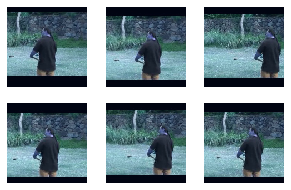

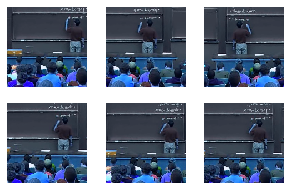

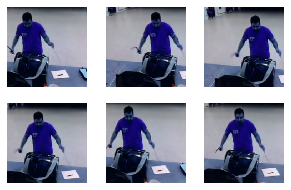

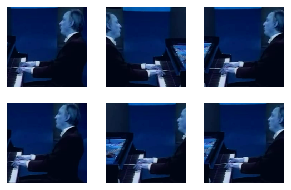

In [11]:
sb = SequenceBatchShower(train_dl, fig_size=5, max_batch_len=4, max_seq_len=6)
print(sb)


sb.showBatch(3, scale=255, permuteToImg=(0,2,3,1))

# Define test set

In [12]:
test_ds = SequenceDataset(
    dataset_path=opt['dataset-path'],
    sequence_length=opt['sequence-length'],
    sample_interval=opt['sample-interval'],
    training=False,
    transform=transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((opt['img_dim'], opt['img_dim']), Image.BICUBIC), 
        transforms.ToTensor(), 
        transforms.Normalize(mean, std),
    ])
)


test_dl = DataLoader(test_ds, batch_size=opt['batch-size'], shuffle=False, num_workers=4)

Number of validation files: 3783


We can see what it contains. Note that in this case, there is no randomness so most likely all frames will be from the same video.

fig-size:5, max_batch_len: 4, max_seq_len: 6
[['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling']]


<Figure size 720x720 with 0 Axes>

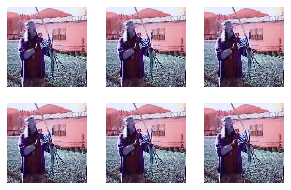

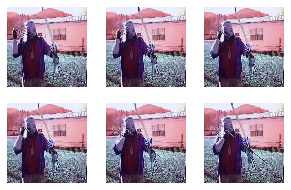

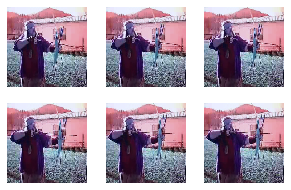

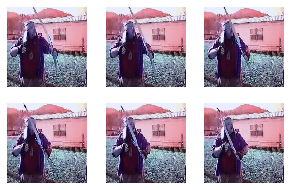

In [13]:
sb = SequenceBatchShower(test_dl, fig_size=5, max_batch_len=4, max_seq_len=6)
print(sb)

sb.showBatch(3, scale=255, permuteToImg=(0,2,3,1))

## Define the model

In [14]:
# Classification criterion
criterion = nn.CrossEntropyLoss().to(device)

# Define network
model = ConvLSTM(
    num_classes=train_ds.num_classes,
    latent_dim=opt['latent-dim'],
    lstm_layers=1,
    hidden_dim=1024,
    bidirectional=True,
    attention=True,
)
model = model.to(device)

Freeze the parameters of the parts we do not want to train and set to true those of the last few layers that we are interested in updating.

The dataset is not large enough to warrant training a full ResNet-50 model. 

To start, we will just fine-tune the output layer and the last BottleNeck block (or residual block). `model.layer4` contains three residual blocks implying model.layer4[2] is the last of these three residual blocks. Fine-tuning only the top layers also reduces the amount of GPU memory, meaning a higher batch size can be used and the model can be trained more quickly with less overfitting.

In [15]:
model

ConvLSTM(
  (encoder): Encoder(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)

In [16]:
for param in model.parameters():
    param.requires_grad_(False)
    
params = []
for param in model.lstm.parameters():
    param.requires_grad_(True)
    params.append(param)
for param in model.output_layers.parameters():
    param.requires_grad_(True)
    params.append(param)
for param in model.attention_layer.parameters():
    param.requires_grad_(True)
    params.append(param)



In [17]:
optimizer = torch.optim.Adam(params, lr=opt['learning-rate'])

In [18]:
if opt['checkpoint-model']:
    print(f"Loading checkpoint model: opt['checkpoint-model']")
    model.load_state_dict(torch.load(opt['checkpoint-model']))

## Training

We have now everything we need to build the training loop. This is done in the next two functions, the first one is to test the model on the validation set and the second one is the actual training loop.

In [19]:
def test_model(model,epoch):
    """ Evaluate the model on the test set """
    print("")
    model.eval()
    test_metrics = {"loss": [], "acc": []}
        
    for batch_i, (X, y) in enumerate(tqdm(test_dl, 'Test', leave=False)):                
        image_sequences = Variable(X.to(device), requires_grad=True).float()
        labels = Variable(y.to(device), requires_grad=False)
            
        labels = labels.squeeze()
        if len(labels.size()) == 0:
            labels = torch.tensor([labels]).to(device)
        
        with torch.no_grad():
            # Reset LSTM hidden state
            model.lstm.reset_hidden_state()
            # Get sequence predictions
            preds = model(image_sequences)
                    
        # Compute metrics
        acc = 100 * (preds.detach().argmax(1) == labels).cpu().numpy().mean()
        loss = criterion(preds, labels).item()
        
        # Keep track of loss and accuracy
        test_metrics["loss"].append(loss)
        test_metrics["acc"].append(acc)
        
        # Log test performance
        sys.stdout.write(
            "\r    Testing | Batch %d/%d | Loss: %f (%f), Acc: %.2f%% (%.2f%%) | "
            % (
                batch_i,
                len(test_dl),
                np.mean(test_metrics["loss"]),
                loss,
                np.mean(test_metrics["acc"]),
                acc,                
            )
        )    
    print("")

In [20]:
def train_model(model, opt, train_dl, test_dl):

    assert 'checkpoint-model' in opt.keys(), "Specify path to checkpoint model or set it to False"
    
    for epoch in tqdm(range(opt['num-epochs']), desc='Epoch #'):
        epoch_metrics = {"loss": [], "acc": []}
        prev_time = time.time()

        #print(f"--- Epoch {epoch} ---")
        for batch_i, (X, y) in enumerate(tqdm(train_dl, 'Train', leave=False)):
            model.train()

            if X.size(0) == 1:
                continue

            image_sequences = Variable(X.to(device), requires_grad=True).float()
            labels = Variable(y.to(device), requires_grad=False)
            
            labels = labels.squeeze()
            if len(labels.size()) == 0:
                labels = torch.tensor([labels]).to(device)

            optimizer.zero_grad()

            # Reset LSTM hidden state
            model.lstm.reset_hidden_state()

            # forward
            with torch.set_grad_enabled(True):
                # Get sequence predictions
                preds = model(image_sequences)

                # Compute metrics   
                loss = criterion(preds, labels)
                acc = 100 * (preds.detach().argmax(1) == labels).cpu().numpy().mean()

                loss.backward()
                optimizer.step()

            # Keep track of epoch metrics
            epoch_metrics["loss"].append(loss.item())
            epoch_metrics["acc"].append(acc)

            # Determine approximate time left
            batches_done = epoch * len(train_dl) + batch_i
            batches_left = opt['num-epochs'] * len(train_dl) - batches_done
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()

            # Print log
            sys.stdout.write(
                "\rEpoch %d/%d | Batch %d/%d | Loss: %f (%f), Acc: %.2f%% (%.2f%%) | ETA: %s"
                % (
                    epoch,
                    opt['num-epochs'],
                    batch_i,
                    len(train_dl),
                    np.mean(epoch_metrics["loss"]),
                    loss.item(),
                    np.mean(epoch_metrics["acc"]),                    
                    acc,
                    time_left,
                )
            )

#             Empty cache
            if torch.cuda.is_available():
                 torch.cuda.empty_cache()

        # Evaluate the model on the test set
        test_model(model, epoch)

        model.train()
        
        # Save model checkpoint
        if epoch % opt['checkpoint_interval'] == 0:
            os.makedirs('model-checkpoints', exist_ok=True)
            torch.save(model.state_dict(), f"model-checkpoints/{model.__class__.__name__}_{epoch}.pth")
            
    # Print log
    print("-------------------------------------------------------")
    sys.stdout.write(
        "\rEpoch %d/%d | Batch %d/%d | Loss: %f (%f), Acc: %.2f%% (%.2f%%) | ETA: %s"
        % (
            epoch+1,
            opt['num-epochs'],
            batch_i,
            len(train_dl),
            np.mean(epoch_metrics["loss"]),
            loss.item(),            
            np.mean(epoch_metrics["acc"]),
            acc,
            time_left,
        )
    )
    
    # save last model
    os.makedirs('model-checkpoints', exist_ok=True)
    random_int = int(np.random.uniform(0,1e14))
    torch.save(model.state_dict(), f"model-checkpoints/{model.__class__.__name__}_{epoch}_{random_int}.pth")
    print("")
    print(f"Model saved as: model-checkpoints/{model.__class__.__name__}_{epoch}_{random_int}.pth")

In [21]:
opt['num-epochs'] = 3

In [22]:
train_model(model, opt, train_dl, test_dl)

Epoch 0/3 | Batch 297/299 | Loss: 1.948858 (0.945441), Acc: 67.08% (90.62%) | ETA: 0:10:45.6293110


    Testing | Batch 118/119 | Loss: 3.206251 (3.774858), Acc: 61.11% (28.57%) | 


Epoch 1/3 | Batch 297/299 | Loss: 0.647301 (0.362026), Acc: 90.87% (96.88%) | ETA: 0:05:23.5804688


    Testing | Batch 118/119 | Loss: 1.549515 (2.800376), Acc: 63.32% (28.57%) | 


Epoch 2/3 | Batch 297/299 | Loss: 0.327708 (0.241228), Acc: 95.68% (93.75%) | ETA: 0:00:02.1536178


    Testing | Batch 118/119 | Loss: 1.421939 (2.866833), Acc: 63.59% (14.29%) |  

-------------------------------------------------------
Epoch 3/3 | Batch 298/299 | Loss: 0.327708 (0.241228), Acc: 95.68% (93.75%) | ETA: 0:00:02.153617Model saved as: model-checkpoints/ConvLSTM_2_4501462956868.pth


In [23]:
# import random
# random_number = np.random.randint(0,16777215)
# hex_number = str(hex(random_number))
# print(hex_number)

In [27]:
torch.save(model.state_dict(), f"model-checkpoints/{model.__class__.__name__}_last-layers.pth")
print(f"Model saved as: model-checkpoints/{model.__class__.__name__}_last-layers.pth")

Model saved as: model-checkpoints/ConvLSTM_last-layers.pth


Unfreeze and train again:

In [28]:
for param in model.parameters():
    param.requires_grad_(True)    

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=opt['learning-rate'])

In [30]:
opt['num-epochs'] = 20
train_model(model, opt, train_dl, test_dl)

Epoch 0/20 | Batch 297/299 | Loss: 0.277079 (0.289144), Acc: 94.80% (90.62%) | ETA: 3:34:53.28701098


    Testing | Batch 118/119 | Loss: 1.663081 (3.095802), Acc: 57.59% (0.00%) |   


Epoch 1/20 | Batch 297/299 | Loss: 0.173515 (0.197344), Acc: 96.29% (96.88%) | ETA: 1:36:44.25531090


    Testing | Batch 118/119 | Loss: 1.603638 (2.395596), Acc: 60.68% (14.29%) |  


Epoch 2/20 | Batch 297/299 | Loss: 0.116877 (0.072388), Acc: 97.61% (100.00%) | ETA: 1:32:31.6137425


    Testing | Batch 118/119 | Loss: 1.650007 (3.068532), Acc: 59.34% (14.29%) | 


Epoch 3/20 | Batch 297/299 | Loss: 0.098077 (0.058992), Acc: 97.90% (96.88%) | ETA: 1:25:45.26402300


    Testing | Batch 118/119 | Loss: 1.656201 (3.750861), Acc: 59.65% (14.29%) | 


Epoch 4/20 | Batch 297/299 | Loss: 0.082650 (0.173378), Acc: 98.10% (93.75%) | ETA: 1:20:28.83883289


    Testing | Batch 118/119 | Loss: 1.731812 (2.580640), Acc: 58.80% (28.57%) | 


Epoch 5/20 | Batch 297/299 | Loss: 0.072728 (0.087797), Acc: 98.42% (100.00%) | ETA: 2:59:04.6555740


    Testing | Batch 118/119 | Loss: 1.791946 (3.172575), Acc: 58.29% (14.29%) | 


Epoch 6/20 | Batch 297/299 | Loss: 0.067492 (0.018564), Acc: 98.35% (100.00%) | ETA: 1:10:31.812663


    Testing | Batch 118/119 | Loss: 1.884980 (2.852966), Acc: 56.45% (14.29%) | 


Epoch 7/20 | Batch 297/299 | Loss: 0.069302 (0.011534), Acc: 98.35% (100.00%) | ETA: 3:27:21.962824


    Testing | Batch 118/119 | Loss: 1.835320 (5.233995), Acc: 58.59% (0.00%) |  


Epoch 8/20 | Batch 297/299 | Loss: 0.054886 (0.113079), Acc: 98.82% (93.75%) | ETA: 0:59:09.6488303


    Testing | Batch 118/119 | Loss: 1.632395 (2.348700), Acc: 61.52% (14.29%) |  


Epoch 9/20 | Batch 297/299 | Loss: 0.058400 (0.063798), Acc: 98.49% (96.88%) | ETA: 0:53:38.2498558


    Testing | Batch 118/119 | Loss: 1.792761 (4.162558), Acc: 59.81% (14.29%) | 


Epoch 10/20 | Batch 297/299 | Loss: 0.055558 (0.038515), Acc: 98.52% (100.00%) | ETA: 0:48:18.220106


    Testing | Batch 118/119 | Loss: 1.975662 (4.426013), Acc: 56.97% (14.29%) | 


Epoch 11/20 | Batch 297/299 | Loss: 0.044560 (0.011655), Acc: 98.88% (100.00%) | ETA: 2:33:50.733052


    Testing | Batch 118/119 | Loss: 1.844240 (3.878876), Acc: 59.73% (14.29%) |  


Epoch 12/20 | Batch 297/299 | Loss: 0.049246 (0.116900), Acc: 98.79% (96.88%) | ETA: 1:30:04.2811816


    Testing | Batch 118/119 | Loss: 2.009103 (4.287604), Acc: 57.63% (14.29%) | 


Epoch 13/20 | Batch 297/299 | Loss: 0.044260 (0.081610), Acc: 98.87% (96.88%) | ETA: 0:32:16.5017645


    Testing | Batch 118/119 | Loss: 1.844133 (4.186693), Acc: 58.13% (14.29%) |  


Epoch 14/20 | Batch 297/299 | Loss: 0.033833 (0.051228), Acc: 99.16% (96.88%) | ETA: 0:26:51.7727463


    Testing | Batch 118/119 | Loss: 1.898353 (3.611306), Acc: 59.16% (0.00%) |  


Epoch 15/20 | Batch 297/299 | Loss: 0.033272 (0.019683), Acc: 99.27% (100.00%) | ETA: 0:21:39.253082


    Testing | Batch 118/119 | Loss: 1.860641 (3.428654), Acc: 59.10% (14.29%) |  


Epoch 16/20 | Batch 297/299 | Loss: 0.032934 (0.027819), Acc: 99.15% (100.00%) | ETA: 0:16:08.214553


    Testing | Batch 118/119 | Loss: 2.054165 (3.552890), Acc: 56.61% (14.29%) | 


Epoch 17/20 | Batch 297/299 | Loss: 0.035109 (0.030853), Acc: 99.05% (96.88%) | ETA: 0:10:46.6607092


    Testing | Batch 118/119 | Loss: 2.154431 (5.002808), Acc: 56.36% (0.00%) |  


Epoch 18/20 | Batch 297/299 | Loss: 0.028810 (0.002933), Acc: 99.32% (100.00%) | ETA: 0:08:48.696885


    Testing | Batch 118/119 | Loss: 1.843788 (4.371943), Acc: 60.50% (0.00%) |  


Epoch 19/20 | Batch 297/299 | Loss: 0.032375 (0.118510), Acc: 99.18% (96.88%) | ETA: 0:00:02.1521071


    Testing | Batch 118/119 | Loss: 2.045525 (4.836757), Acc: 58.25% (0.00%) |   

-------------------------------------------------------
Epoch 20/20 | Batch 298/299 | Loss: 0.032375 (0.118510), Acc: 99.18% (96.88%) | ETA: 0:00:02.152107Model saved as: model-checkpoints/ConvLSTM_19_30153958022855.pth


In [24]:
from nbdev.export import *
notebook2script()

Converted 00_core-baseline.ipynb.
Converted 00_core-sequence.ipynb.
Converted 01_dataset_ucf101.ipynb.
Converted 02_avi.ipynb.
Converted 04_data_augmentation.ipynb.
Converted 05_models.ipynb.
Converted 06_utils.ipynb.
Converted index.ipynb.
